In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# a) データ読み込み直後に一度だけ計算しておく
all_vels = np.load("./dataset_one_batch/train_vels.npy")   # shape (800,1,70,70)
vel_min, vel_max = all_vels.min(), all_vels.max()

# b) Dataset 内で正規化／逆正規化
class NormWaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path, vel_min, vel_max):
        self.waves = np.load(waves_path).astype(np.float32)
        self.vels  = np.load(vels_path).astype(np.float32)
        self.vmin, self.vmax = vel_min, vel_max

    def __len__(self): return len(self.waves)
    def __getitem__(self, idx):
        x = self.waves[idx]
        # 波形は global 統計で標準化しても良いです（ここでは簡易に min-max）
        x = (x - x.min()) / (x.max() - x.min())
        y = self.vels[idx]
        # 速度は [vel_min,vel_max] → [0,1]
        y_norm = (y - self.vmin) / (self.vmax - self.vmin)
        return torch.from_numpy(x).float(), torch.from_numpy(y_norm).float()

# c) DataLoader 作成（num_workers=0 推奨）
train_ds = NormWaveformDataset("./dataset_one_batch/train_waves.npy",
                               "./dataset_one_batch/train_vels.npy",
                               vel_min, vel_max)
val_ds   = NormWaveformDataset("./dataset_one_batch/val_waves.npy",
                               "./dataset_one_batch/val_vels.npy",
                               vel_min, vel_max)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """2回連続 Conv→BN→ReLU のブロック"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class WaveformUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # --- Encoder ---
        self.inc   = DoubleConv(5,  32)              # 入力波形 5ch→32ch, size=(1000,70)
        self.down1 = nn.Sequential(nn.MaxPool2d((2,2)), DoubleConv(32, 64))   # →(500,35)
        self.down2 = nn.Sequential(nn.MaxPool2d((2,2)), DoubleConv(64,128))   # →(250,17)
        self.down3 = nn.Sequential(nn.MaxPool2d((2,2)), DoubleConv(128,256))  # →(125,8)
        # --- Bottleneck ---
        self.bot   = DoubleConv(256, 256)           # →(125,8)
        # --- Decoder ---
        self.up3   = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)  # →(250,16)
        self.dec3  = DoubleConv(256,128)
        self.up2   = nn.ConvTranspose2d(128,64, kernel_size=2,stride=2)  # →(500,32)
        self.dec2  = DoubleConv(128,64)
        self.up1   = nn.ConvTranspose2d(64,32,  kernel_size=2,stride=2)  # →(1000,64)
        self.dec1  = DoubleConv(64,32)
        # --- Final conv ---
        self.outc  = nn.Conv2d(32, 1, kernel_size=1)  # →(1000,64)→(1000,1,64)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)       # [B,32,1000,70]
        x2 = self.down1(x1)    # [B,64,500,35]
        x3 = self.down2(x2)    # [B,128,250,17]
        x4 = self.down3(x3)    # [B,256,125,8]
        # Bottleneck
        xb = self.bot(x4)      # [B,256,125,8]
        # Decoder + skip connections
        x = self.up3(xb)                                 # [B,128,250,16]
        x = torch.cat([x, x3[:,:, :250, :16]], dim=1)    # チャネル結合
        x = self.dec3(x)                                 # [B,128,250,16]
        x = self.up2(x)                                  # [B,64,500,32]
        x = torch.cat([x, x2[:,:, :500, :32]], dim=1)
        x = self.dec2(x)                                 # [B,64,500,32]
        x = self.up1(x)                                  # [B,32,1000,64]
        x = torch.cat([x, x1[:,:, :1000, :64]], dim=1)
        x = self.dec1(x)                                 # [B,32,1000,64]
        # 最終出力
        x = self.outc(x)  # [B,1,1000,64]
        # --- 時間軸(1000)→70 & 空間軸(64)→70 に縮小 ---
        x = F.adaptive_avg_pool2d(x, (70, 70))  # → [B,1,70,70]
        return x

# 確認
if __name__ == "__main__":
    model = WaveformUNet()
    inp = torch.randn(2,5,1000,70)
    out = model(inp)
    print(out.shape)  # torch.Size([2, 1, 70, 70])


torch.Size([2, 1, 70, 70])


In [4]:
# モデルを GPU に載せる
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveformUNet().to(device)


# オプティマイザ & スケジューラ
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)
criterion = nn.L1Loss()


In [5]:
num_epochs = 100
import torch

# --- チェックポイント用変数の初期化 ---
best_val_loss = float("inf")
best_epoch    = 0
save_path     = "./best_model.pth"

# もし過去のチェックポイントがあれば読み込む例
# try:
#     ckpt = torch.load(save_path)
#     model.load_state_dict(ckpt["model_state_dict"])
#     optimizer.load_state_dict(ckpt["optimizer_state_dict"])
#     best_val_loss = ckpt["val_loss"]
#     best_epoch    = ckpt["epoch"]
#     print(f"Loaded checkpoint from epoch {best_epoch}, val_loss={best_val_loss:.4f}")
# except FileNotFoundError:
#     pass

train_losses = []
val_losses   = []

for epoch in range(1, num_epochs+1):
    # --- Training ---
    model.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)
    epoch_train_loss = running_train / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            running_val += criterion(preds, yb).item() * xb.size(0)
    epoch_val_loss = running_val / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # --- 学習率スケジューラ更新 ---
    scheduler.step(epoch_val_loss)

    # --- ベストモデルの保存判定 ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch    = epoch
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": epoch_val_loss,
        }, save_path)
        print(f"*** New best model saved at epoch {epoch} (val_loss={epoch_val_loss:.4f}) ***")

    # --- ログ出力 ---
    print(f"Epoch {epoch:02d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

print(f"Training finished, best epoch={best_epoch}, best val_loss={best_val_loss:.4f}")


*** New best model saved at epoch 1 (val_loss=0.2402) ***
Epoch 01 | Train Loss: 0.1704 | Val Loss: 0.2402
*** New best model saved at epoch 2 (val_loss=0.1979) ***
Epoch 02 | Train Loss: 0.1478 | Val Loss: 0.1979
*** New best model saved at epoch 3 (val_loss=0.1833) ***
Epoch 03 | Train Loss: 0.1444 | Val Loss: 0.1833
Epoch 04 | Train Loss: 0.1410 | Val Loss: 0.1909
Epoch 05 | Train Loss: 0.1364 | Val Loss: 0.2589
*** New best model saved at epoch 6 (val_loss=0.1778) ***
Epoch 06 | Train Loss: 0.1368 | Val Loss: 0.1778
Epoch 07 | Train Loss: 0.1339 | Val Loss: 0.2329
*** New best model saved at epoch 8 (val_loss=0.1755) ***
Epoch 08 | Train Loss: 0.1320 | Val Loss: 0.1755
Epoch 09 | Train Loss: 0.1303 | Val Loss: 0.3264
Epoch 10 | Train Loss: 0.1313 | Val Loss: 0.2453
*** New best model saved at epoch 11 (val_loss=0.1623) ***
Epoch 11 | Train Loss: 0.1313 | Val Loss: 0.1623
Epoch 12 | Train Loss: 0.1297 | Val Loss: 0.3414
Epoch 13 | Train Loss: 0.1287 | Val Loss: 0.4350
Epoch 14 | Tra

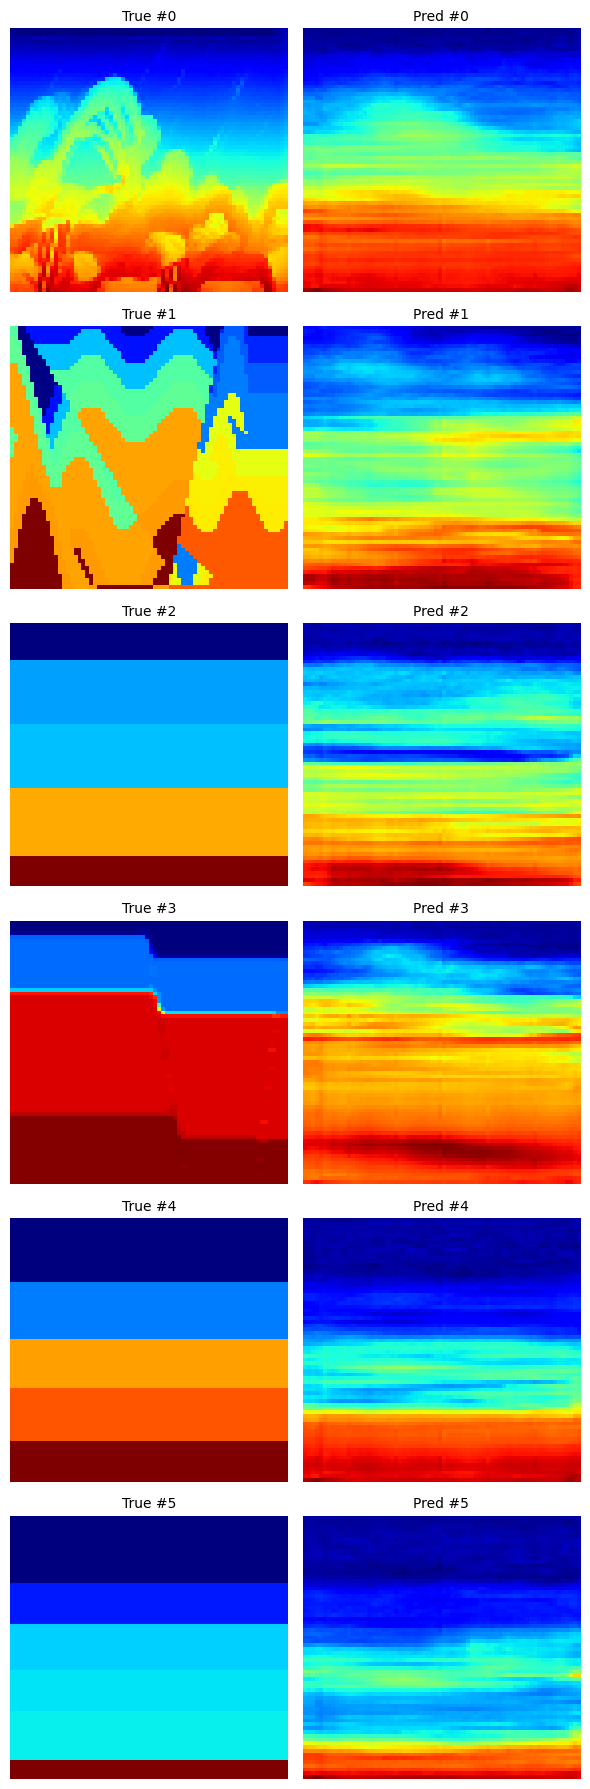

In [6]:
import matplotlib.pyplot as plt

# --- 1) モデルを評価モードにして、検証データの最初のバッチを取得 ---
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))               # バッチ取得
    preds = model(xb.to(device)).cpu().numpy()    # 予測結果 (B,1,70,70)
    truths = yb.numpy()                           # 真の値 (B,1,70,70)

# --- 2) 描画するサンプル数 ---
n_show = 6   # 例: 最初の6サンプルを表示
cols   = 2   # 真 vs 予測
rows   = n_show

fig, axes = plt.subplots(rows, cols, figsize=(6, 3*rows))
for i in range(n_show):
    ax_true = axes[i,0]
    ax_pred = axes[i,1]
    # 真の速度マップ
    ax_true.imshow(truths[i,0], cmap='jet', aspect='auto')
    ax_true.set_title(f"True #{i}", fontsize=10)
    ax_true.axis('off')
    # 予測速度マップ
    ax_pred.imshow(preds[i,0], cmap='jet', aspect='auto')
    ax_pred.set_title(f"Pred #{i}", fontsize=10)
    ax_pred.axis('off')

plt.tight_layout()
plt.show()


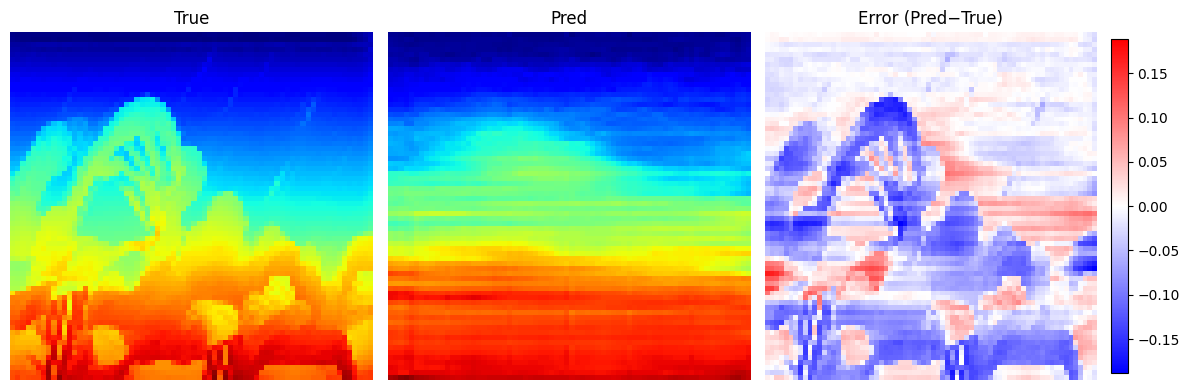

In [7]:
import matplotlib.pyplot as plt

# ① 検証データから一つサンプルを取得
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))
    pred = model(xb.to(device)).cpu().numpy()[0,0]  # 1 枚取り出し
    true = yb.numpy()[0,0]

# ② 誤差マップを計算
error = pred - true

# ③ 真値・予測・誤差 を並べて表示
fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].imshow(true, cmap='jet', aspect='auto')
axes[0].set_title("True")
axes[0].axis('off')

axes[1].imshow(pred, cmap='jet', aspect='auto')
axes[1].set_title("Pred")
axes[1].axis('off')

im = axes[2].imshow(error, cmap='bwr', aspect='auto', vmin=-np.max(np.abs(error)), vmax=np.max(np.abs(error)))
axes[2].set_title("Error (Pred−True)")
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


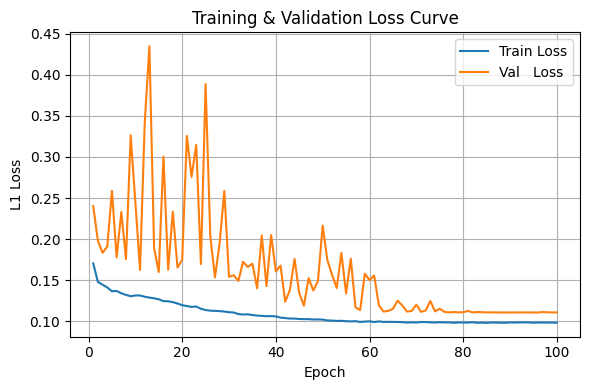

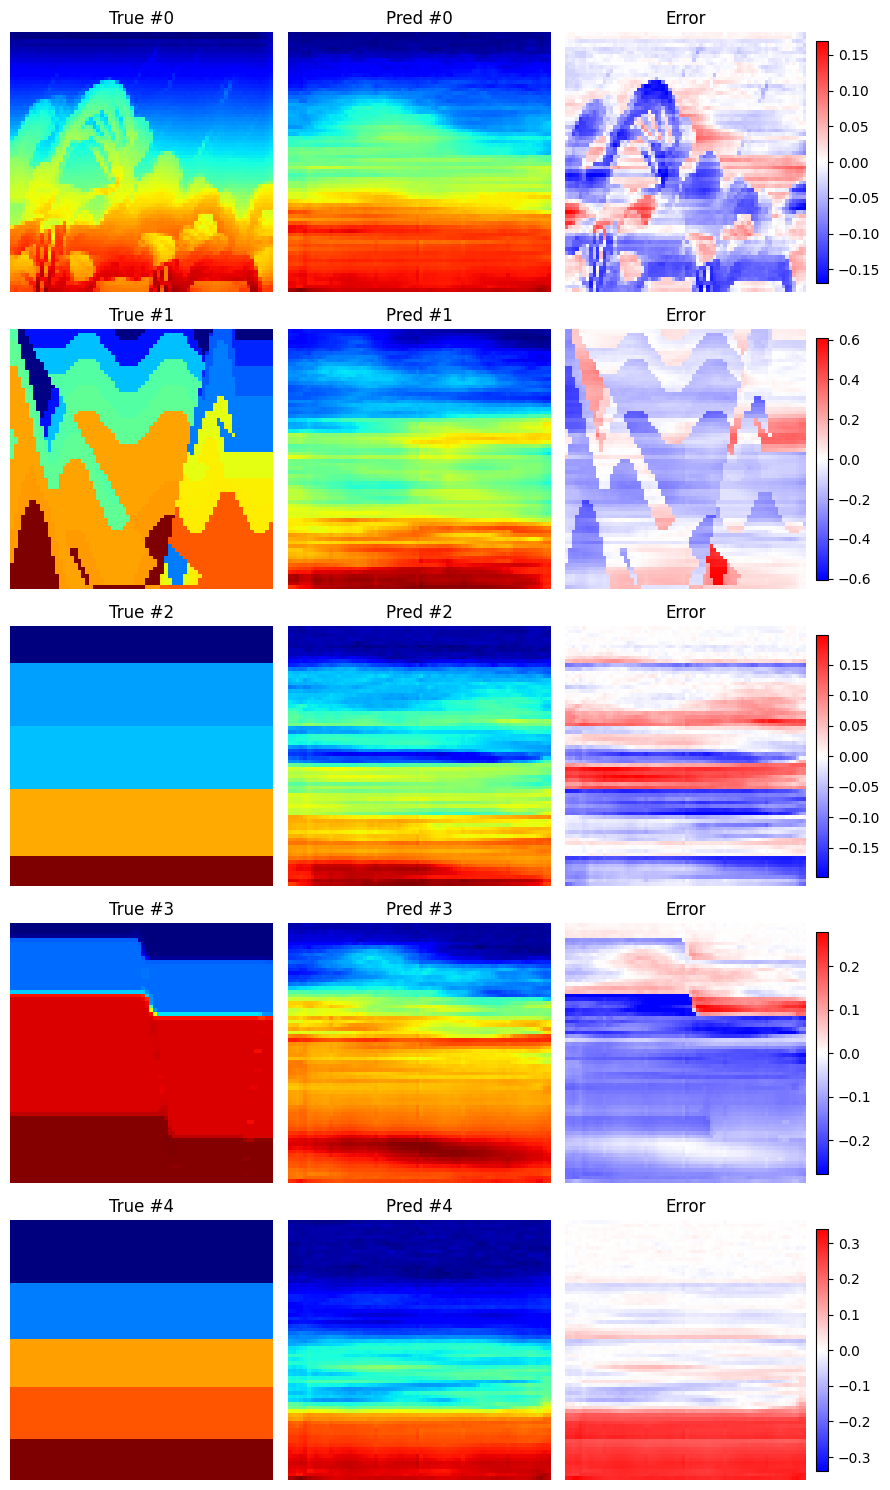

In [8]:
import matplotlib.pyplot as plt

# ===== (1) 損失カーブをプロット =====
# 事前に各 epoch の train_loss_list, val_loss_list をリストに保存しておく想定
# もし保存していない場合は、学習ループ内で append するように修正してください。

epochs = list(range(1, num_epochs+1))
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training & Validation Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ===== (2) 検証データでの予測例を可視化 =====
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))
    preds = model(xb.to(device)).cpu().numpy()

n_show = 5  # 表示サンプル数
fig, axes = plt.subplots(n_show, 3, figsize=(9, 3*n_show))
for i in range(n_show):
    true = yb[i,0].numpy()
    pred = preds[i,0]
    err  = pred - true

    ax1, ax2, ax3 = axes[i]
    ax1.imshow(true, cmap="jet", aspect="auto")
    ax1.set_title(f"True #{i}")
    ax1.axis("off")

    ax2.imshow(pred, cmap="jet", aspect="auto")
    ax2.set_title(f"Pred #{i}")
    ax2.axis("off")

    im = ax3.imshow(err, cmap="bwr", aspect="auto",
                    vmin=-err.max(), vmax=err.max())
    ax3.set_title("Error")
    ax3.axis("off")
    fig.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [9]:
import numpy as np

# ① train_v　または全データから min,max を再取得
vels = np.load("./dataset_one_batch/train_vels.npy")  # shape (800,1,70,70)
vmin, vmax = vels.min(), vels.max()
print("vel_min:", vmin, "vel_max:", vmax)

# ② 正規化後の L1Loss を変数に持っているとする
norm_mae = 0.1191

# ③ 元スケールでの MAE を計算
real_mae = norm_mae * (vmax - vmin)
print(f"実際の MAE ≃ {real_mae:.1f} （速度単位）")


vel_min: 1501.0 vel_max: 4500.0
実際の MAE ≃ 357.2 （速度単位）
